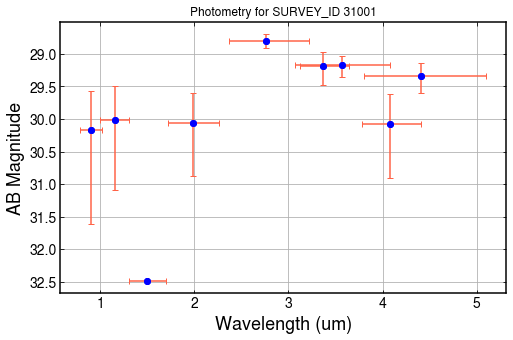

In [4]:
from astropy.io import fits
from astropy.table import Table
import matplotlib.pyplot as plt
import numpy as np

# Load the file
hdulist = fits.open("/raid/scratch/work/austind/GALFIND_WORK/Catalogues/v13/ACS_WFC+NIRCam/JADES-DR3-GN/(0.32)as/JADES-DR3-GN_MASTER_Sel-F277W+F356W+F444W_v13.fits")
table_objects = Table(hdulist[4].data)
hdulist.close()
#print(table_objects.colnames)

# Find the row index where SURVEY_ID ==  target ID 
target_id = 31001  # put galaxy's SURVEY_ID here
index = (table_objects['SURVEY_ID'] == target_id).nonzero()[0]

if len(index) == 0:
    print(f"SURVEY_ID {target_id} not found!")
else:
    # Extract only that row
    one_galaxy_data = table_objects[index[0]]
    # Convert just that row to an Astropy Table with one row
    table_one_galaxy = Table(one_galaxy_data)

#convert wavelengths from Angstroms to micrometers 
filters = Table.read('wavelengths_filters.csv', format='csv')
wavelengths = filters['wavelength_A'] / 1e4
wavelength_min = filters['wavelength_min_A'] / 1e4
wavelength_max = filters['wavelength_max_A'] / 1e4
# Calculate errors for wavelengths (distance from central wavelength to min and max)
wavelength_err_lower = wavelengths - wavelength_min  # distance from center to min
wavelength_err_upper = wavelength_max - wavelengths  # distance from center to max

# Combine into a 2D array: [[lower_errors], [upper_errors]]
wavelength_err = np.vstack((wavelength_err_lower, wavelength_err_upper))

# Extract the flux filter names and create a list of flux columns
filters_list = filters['flux_filter'].tolist()
flux_columns = [f'FLUX_APER_{f}_aper_corr_Jy' for f in filters_list]
fluxes_one_galaxy = [one_galaxy_data[col] for col in flux_columns]
fluxes_jy = np.array(fluxes_one_galaxy)
# Replace any zero or negative fluxes (which cannot be converted to mags) with np.nan to avoid errors
fluxes_jy = np.where(fluxes_jy > 0, fluxes_jy, np.nan)
# Convert to AB magnitudes
ab_magnitudes = -2.5 * np.log10(fluxes_jy / 3631)

#vertical error bars for magnitudes
fluxerr_columns = [f'FLUXERR_APER_{f}_loc_depth_10pc_Jy' for f in filters_list]
fluxerrs_one_galaxy = [one_galaxy_data[col] for col in fluxerr_columns]
fluxerrs_jy = np.array(fluxerrs_one_galaxy)
# Mask for positive fluxes where flux - flux_err is still positive
valid_mask = (fluxes_jy > 0) & ((fluxes_jy - fluxerrs_jy) > 0)
mag_err_plus = np.full_like(fluxes_jy, np.nan)
mag_err_minus = np.full_like(fluxes_jy, np.nan)

mag_err_plus[valid_mask] = np.abs(-2.5 * np.log10((fluxes_jy[valid_mask] + fluxerrs_jy[valid_mask]) / fluxes_jy[valid_mask]))
mag_err_minus[valid_mask] = np.abs(-2.5 * np.log10((fluxes_jy[valid_mask] - fluxerrs_jy[valid_mask]) / fluxes_jy[valid_mask]))
yerr = np.vstack((mag_err_plus, mag_err_minus))




plt.figure(figsize=(8,5))
plt.scatter(wavelengths, ab_magnitudes, color='blue')
plt.errorbar(wavelengths, ab_magnitudes, xerr=wavelength_err, yerr= yerr, fmt='o', color='blue', ecolor='tomato', elinewidth=1.5, capsize=3)
plt.gca().invert_yaxis()  # Magnitude scale is inverted: brighter objects have smaller mags
plt.xlabel('Wavelength (um)')
plt.ylabel('AB Magnitude')
plt.title(f'Photometry for SURVEY_ID {target_id}')
plt.grid(True)

plt.show()









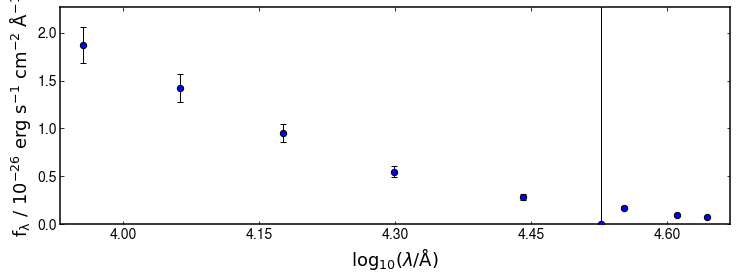

In [5]:
import numpy as np 
import bagpipes as pipes
import matplotlib.pyplot as plt
from astropy.table import Table

from astropy.io import fits
import matplotlib as mpl

#performing bagpipes SED fitting on JWST


def load_goodss(ID):
    """ Load JADES photometry from catalogue. """

    # Load the 4th extension (index 3) from the FITS catalogue
    cat = Table.read("JADES-DR3-GS_MASTER_Sel-F277W+F356W+F444W_v13.fits", hdu=4)
    #print(cat.colnames)


    # Load filters info from CSV (make sure the file path is correct)
    filters = Table.read('wavelengths_filters.csv', format='csv')

    # Convert ID to 0-based index for the table
    row = int(ID) - 1

    # Extract filter names
    filters_list = filters['flux_filter'].tolist()

    # Build column names for fluxes and flux errors
    flux_columns = [f'FLUX_APER_{f}_aper_corr_Jy' for f in filters_list]
    fluxerr_columns = [f'FLUXERR_APER_{f}_loc_depth_10pc_Jy' for f in filters_list]
     # Extract fluxes and errors for this galaxy from the catalogue
    fluxes = np.array([cat[row][col] for col in flux_columns])
    fluxes = np.where(fluxes > 0, fluxes, np.nan)
    fluxerrs = np.array([cat[row][col] if not np.ma.is_masked(cat[row][col]) else np.nan for col in fluxerr_columns])


    # Turn these into a 2D array.
    photometry = np.c_[fluxes, fluxerrs]

    # blow up the errors associated with any missing fluxes.
    for i in range(len(photometry)):
        if (photometry[i, 0] == 0.) or (photometry[i, 1] <= 0) or np.isnan(photometry[i, 0]) or np.isnan(photometry[i, 1]):

            photometry[i,:] = [0., 9.9*10**99.]
            
    # Enforce a maximum SNR of 20, or 10 in the IRAC channels.
    for i in range(len(photometry)):
        if i < 10:
            max_snr = 20.
            
        else:
            max_snr = 10.
        
        if photometry[i, 0]/photometry[i, 1] > max_snr:
            photometry[i, 1] = photometry[i, 0]/max_snr

    return photometry

goodss_filt_list = np.loadtxt("filters1/goodss_filt_list1.txt", dtype="str")

galaxy = pipes.galaxy("31001", load_goodss, spectrum_exists=False, filt_list=goodss_filt_list)
fig = galaxy.plot()


In [6]:
#fit instructions dictionary
exp = {}                                  # Tau-model star-formation history component
exp["age"] = (0.1, 15.)                   # Vary age between 100 Myr and 15 Gyr. In practice 
                                          # the code automatically limits this to the age of
                                          # the Universe at the observed redshift.

exp["tau"] = (0.3, 10.)                   # Vary tau between 300 Myr and 10 Gyr
exp["massformed"] = (1., 15.)             # vary log_10(M*/M_solar) between 1 and 15
exp["metallicity"] = (0., 2.5)            # vary Z between 0 and 2.5 Z_oldsolar

dust = {}                                 # Dust component
dust["type"] = "Calzetti"                 # Define the shape of the attenuation curve
dust["Av"] = (0., 2.)                     # Vary Av between 0 and 2 magnitudes

nebular = {}                      # Nebular emission component
nebular["logU"] = -3.             # log_10(ionization parameter)

fit_instructions = {}                     # The fit instructions dictionary
fit_instructions["redshift"] = (0., 10.)  # Vary observed redshift from 0 to 10
fit_instructions["exponential"] = exp   
fit_instructions["dust"] = dust
fit_instructions["nebular"] = nebular


In [7]:
#performing the fit

fit = pipes.fit(galaxy, fit_instructions)

fit.fit(verbose=False)

Generating 500 samples from posterior. Total samples: 1851

Results loaded from pipes/posterior/./31001.h5

Fitting not performed as results have already been loaded from pipes/posterior/./31001.h5. To start over delete this file or change run.



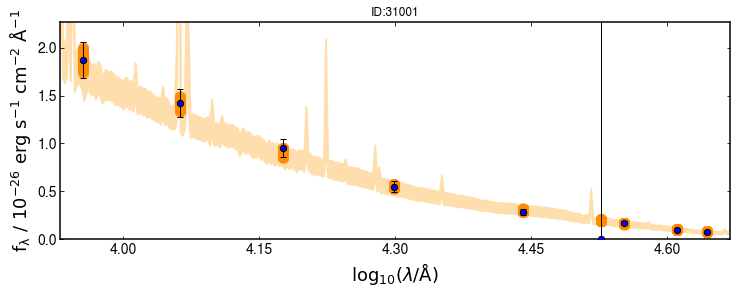

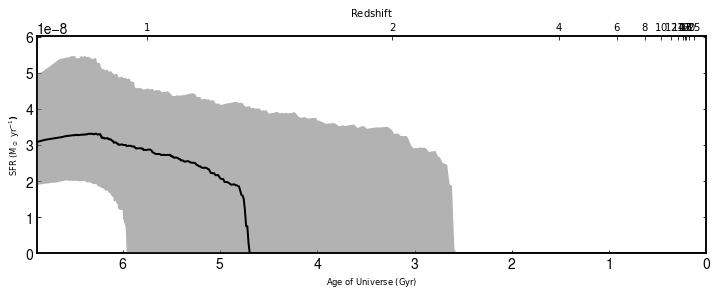

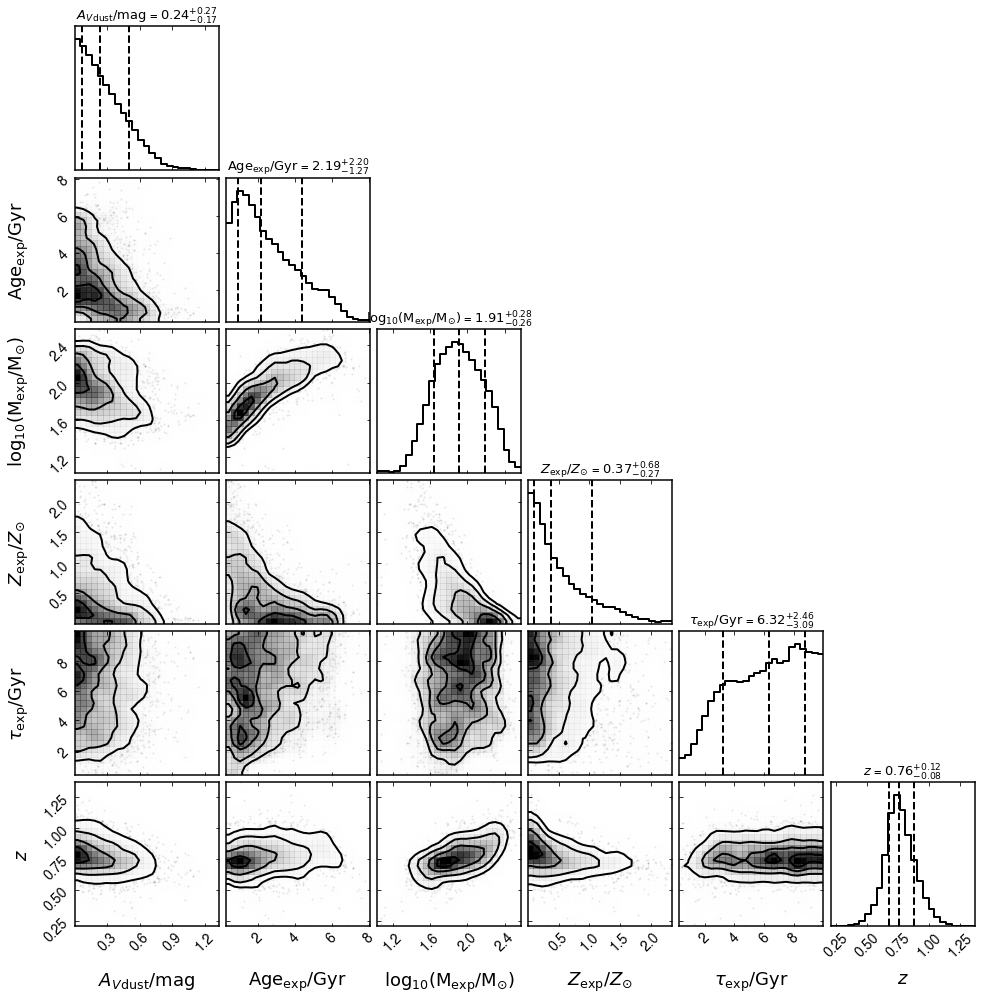

In [8]:
fig = fit.plot_spectrum_posterior(save=False, show=True) # Shows the input and fitted spectrum/photometry
fig = fit.plot_sfh_posterior(save=False, show=True) # Shows the fitted star-formation history
fig = fit.plot_corner(save=False, show=True) #corner plot: # Shows 1d and 2d posterior probability distributions